Importing The needed libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import math
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import statistics
from statistics import mode
from sklearn import metrics
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Downloading the dataset

In [ ]:
!unzip /content/gdrive/MyDrive/pattern_assignment2/kddcup.data_10_percent.zip

Archive:  /content/gdrive/MyDrive/pattern_assignment2/kddcup.data_10_percent.zip
replace kddcup.data_10_percent/kddcup.data_10_percent? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data=pd.read_csv('/content/kddcup.data_10_percent/kddcup.data_10_percent',header=None)

Change the categorical features to numerical

In [ ]:
#The unique labels of col#1
labels_tcp=pd.unique(data[1])
# num of labels
tcp_size=list(range(0,labels_tcp.shape[0]))
# replacing each labels with its adjacent number
data[1]=data[1].replace(labels_tcp,tcp_size)

#The unique labels of col#2
labels_http=pd.unique(data[2])
http_size=list(range(0,labels_http.shape[0]))
data[2]=data[2].replace(labels_http,http_size)

#The unique labels of col#3
labels_SF=pd.unique(data[3])
SF_size=list(range(0,labels_SF.shape[0]))
data[3]=data[3].replace(labels_SF,SF_size)

Dropping the duplicates

In [ ]:
data.drop_duplicates(keep="last", inplace=True)

Downloading the test dataset

In [ ]:
!unzip /content/gdrive/MyDrive/pattern_assignment2/corrected.zip

Archive:  /content/gdrive/MyDrive/pattern_assignment2/corrected.zip
replace corrected/corrected? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data_test=pd.read_csv('/content/corrected/corrected',header=None)

Change the categorical features to numerical (Test Set)

In [ ]:
data_test[1]=data_test[1].replace(labels_tcp,tcp_size)

data_test[2]=data_test[2].replace(labels_http,http_size)
data_test[2]=data_test[2].replace('icmp',66)
data_test[3]=data_test[3].replace(labels_SF,SF_size)

Dropping the duplicates (Test Set)

In [ ]:
data_test.drop_duplicates(keep="last", inplace=True)

Kmeans

In [ ]:
def Kmeans(data,k):
  random_starts = []
  # Changing the format of data to pandas
  data=pd.core.frame.DataFrame(data)
  scale = StandardScaler()
  if(data.shape[1]==42):
    data_train= np.array(data.iloc[:, : data.shape[1]-1])
    # Scaling the data.set for better results
    data_train = scale.fit_transform(data_train)
  else:
    data_train=np.array(data)
    data_train = scale.fit_transform(data_train)
    #number of random starts
  for i in range(1):
    # picking random starts to be the inital centroid
      random_starts.append(rn.sample(range(0,data_train.shape[0]),k))
  centroids = np.empty((k,data_train.shape[1]))
  ncentroids = np.empty((k,data_train.shape[1]))
  error = 1
  SSE = 0
  temp= [[] for _ in range(k)]
  for i in range(len(random_starts)):
      for j in range(k):
        # centroids==random_starts
          centroids[j] = data_train[random_starts[i][j]]
      error=1
      # error = new centroids - old centroids
      while error != 0:
        clusters = [[] for _ in range(k)]
        # Computing the euclidean distance
        distances = cdist(data_train, centroids,'euclidean')
        closest_centroid=np.argmin(distances, axis=1)
        # Clustering the data according to the nearest centroid
        for f in range(data_train.shape[0]):
          clusters[ closest_centroid[f] ].append(f)
        error=0
        for z in range(k):
            sum = np.zeros(data_train.shape[1])
            for idx in clusters[z]:
                    sum =  sum + data_train[idx]
            if (len(clusters[z]) != 0):
              ncentroids[z] = sum/len(clusters[z])
            error = error + (centroids[z] - ncentroids[z]).sum()
        ncentroids=np.array(ncentroids)
        centroids=np.array(ncentroids)
      # Computing the SSE to check the best inital centrioid to start with
      distances = np.sum((data_train[:, np.newaxis] - centroids)**2, axis=2)
      cluster_indices = np.argmin(distances, axis=1)
      SSE = np.sum(distances[np.arange(len(cluster_indices)), cluster_indices])
      if i == 0:
          min_SSE = SSE
          BestCluster=clusters
          BestCentroids=centroids
      else:
          if SSE < min_SSE:
              min_SSE = SSE
              BestCluster=clusters
              BestCentroids=centroids
  return clusters,centroids

In [ ]:
clusters,centroids=Kmeans(data,23)

Testing the dataset with Kmeans

In [ ]:
def Kmeans_test(data_test,centroids,k):
  # removing the labels
  data= np.array(data_test.iloc[:, : data_test.shape[1]-1])
  # Labels
  y_test=data_test.iloc[:,41:]
  # changing format of the data
  data_test=np.array(data_test)
  scale = StandardScaler()
  # scaling the data
  data = scale.fit_transform(data)
  clusters = [[] for _ in range(k)]
  # Computing the clusters according to the Trainset's centroids
  distances = cdist(data, centroids,'euclidean')
  closest_centroid=np.argmin(distances, axis=1)
  y=np.empty([data.shape[0]],dtype='object')
  for f in range(data.shape[0]):
    clusters[ closest_centroid[f] ].append(f)
  labels=[]
  # Computing the Y_Predict
  for q in range(k):
    y_predict=[]
    for p in clusters[q]:
      y_predict.append(data_test[p,41])
    if not y_predict:
      labels.append('empty')
    else:
      labels.append(mode(y_predict))
  for q in range(k):
    for p in clusters[q]:
      y[p]=labels[q]

  return clusters,y,y_test

In [ ]:
Clusters_test,Y_predict,Y_test=Kmeans_test(data_test,centroids,31)

In [ ]:
#Unique labels
targets = pd.unique(data_test[41])

Downloading the dataset for Spectral clustering

In [ ]:
!unzip /content/gdrive/MyDrive/pattern_assignment2/kddcup.data.zip

Archive:  /content/gdrive/MyDrive/pattern_assignment2/kddcup.data.zip
replace kddcup.data/kddcup.data? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data_cluster=pd.read_csv('/content/kddcup.data/kddcup.data',header=None)

Change the categorical features to numerical and dropping the duplicates (Spectral Clustering dataset)

In [ ]:
labels_tcp2=pd.unique(data_cluster[1])
tcp_size2=list(range(0,labels_tcp2.shape[0]))
data_cluster[1]=data_cluster[1].replace(labels_tcp2,tcp_size2)

labels_http2=pd.unique(data_cluster[2])
http_size2=list(range(0,labels_http2.shape[0]))
data_cluster[2]=data_cluster[2].replace(labels_http2,http_size2)

labels_SF2=pd.unique(data_cluster[3])
SF_size2=list(range(0,labels_SF2.shape[0]))
data_cluster[3]=data_cluster[3].replace(labels_SF2,SF_size2)

data_cluster.drop_duplicates(keep="last", inplace=True)

In [ ]:
X=data_cluster.iloc[:, :]
Y=data_cluster.iloc[:,41:]

Spliting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.9975,stratify =Y,random_state=42)

**Spectral_Clustering**

In [ ]:
def Spectral_clustering(data,k,g):
  data=np.array(data.iloc[:,:41])
  # Similarity Matrix using rbf_kernel
  similarity_matrix=rbf_kernel(data, gamma=g)
  # Computing the delta
  delta=np.sum(similarity_matrix,axis=1)
  delta_diagonal=np.diag(delta)
  # Laplacian Matrix
  L=delta_diagonal.T-similarity_matrix
  LAC=np.dot(np.linalg.inv(delta_diagonal),L)
  # Computing the eigen vectors
  w,v=np.linalg.eig(LAC)
  idx = np.argsort(w)
  EigenValues=w[idx]
  EigenVectors=v[:,idx]
  EigenVectors =EigenVectors[:,:k]
  EigenVectors = EigenVectors.real
  norm=EigenVectors.real / np.sqrt(np.linalg.norm(EigenVectors.real))
  # Clustering using Kmeans
  C_K ,centroids=Kmeans(norm,k)
  return C_K

computing the clusters at K=23 gamma=0.01

In [ ]:
C_K=Spectral_clustering(X_train,23,0.01)

In [ ]:
y_train=np.array(y_train)
y_train=y_train.flatten()

Computing the Y_predict for spectral Clustering at k=23

In [ ]:
y=np.empty([y_train.shape[0]],dtype='object')
labels=[]
k=23
for q in range(k):
    y_predict=[]
    for p in C_K[q]:
      y_predict.append((y_train[p]))
    if not y_predict:
      labels.append('empty')
    else:
      labels.append(mode(y_predict))
for q in range(k):
  for p in C_K[q]:
      y[p]=labels[q]

In [ ]:
def Evaluation(y_true,y_predict,data_arr, clusters, targets):
  y_true=np.array(y_true)
  y_true=y_true.flatten()
  y_predict=np.array(y_predict)
  labels=pd.unique(y_true)
  cm=confusion_matrix(y_true,y_predict)

  FP = cm.sum(axis=0) - np.diag(cm)
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)

  preci=TP/(TP+FP)
  recall=TP/(TP+FN)

  preci=np.nan_to_num(preci, nan=0)

  recall =np.nan_to_num(recall, nan=0)

  weights = np.sum(cm, axis=1) / np.sum(cm)
  weighted_preci = np.sum(preci *weights )
  weighted_recall = np.sum(recall * weights)
  F_score= 2*weighted_preci*weighted_recall/(weighted_preci+weighted_recall)
  weighted_Fscore= np.sum(F_score * weights)

  data_arr=np.array(data_arr)
  TgivenC = np.zeros(len(clusters))
  indx = 0
  entropy = 0
  for cluster in clusters:
      count = np.zeros(len(targets))
      for i in cluster:
          for j in range(len(targets)):
              if data_arr[i,-1] == targets[j]:
                  count[j] = count[j] + 1
                  break
      for z in count:
          if z == 0:
              continue
          TgivenC[indx] = TgivenC[indx] - ((z/len(cluster)) * math.log(z/len(cluster)))
      entropy = entropy + ((len(cluster)/len(data_arr)) * TgivenC[indx])
      indx = indx + 1
  entropy = entropy * 1/len(TgivenC)


  print('Model precision = ' +str(weighted_preci*100)+'%')
  print('Model recall = ' +str(weighted_recall*100)+'%')
  print('Model f_sore = ' +str(weighted_Fscore*100)+'%')
  print('Condition entropy = '+str(entropy))


Kmeans Evaluation

In [ ]:
np.seterr(invalid='ignore')

ks=[7,15,23,31,45]
for k in ks:
  clusters,centroids=Kmeans(data,k)
  Clusters_test,Y_predict,Y_test=Kmeans_test(data_test,centroids,k)
  print('Evaluation for k = '+str(k))
  Evaluation(Y_test,Y_predict,data_test,Clusters_test,targets)
  print('\n')


Evaluation for k = 7
Model precision = 78.12370255153161%
Model recall = 88.27547838687558%
Model f_sore = 82.889917813275%
Condition entropy = 0.072010656786981


Evaluation for k = 15
Model precision = 84.44325818529786%
Model recall = 89.9781345822929%
Model f_sore = 87.122877864966%
Condition entropy = 0.024501952752237273


Evaluation for k = 23
Model precision = 84.74479664106875%
Model recall = 90.45684491079167%
Model f_sore = 87.50770664998181%
Condition entropy = 0.01481902772802903


Evaluation for k = 31
Model precision = 86.23352693134704%
Model recall = 90.37792239717429%
Model f_sore = 88.25709810623607%
Condition entropy = 0.010091591188471123


Evaluation for k = 45
Model precision = 87.63446590664088%
Model recall = 91.41297175609063%
Model f_sore = 89.4838492117814%
Condition entropy = 0.006137615660265664




Kmeans for datatset = 0.025 of the total data

In [ ]:
clusters,centroids=Kmeans(X_train,23)
Clusters_test,Y_predict,Y_test=Kmeans_test(X_train,centroids,k)

Kmeans vs Spectral clustering

In [ ]:
np.seterr(invalid='ignore')

# Evaluation for Kmeans
clusters,centroids=Kmeans(X_train,23)
Clusters_test,Y_predict,Y_test=Kmeans_test(X_train,centroids,k)
print('Evaluation for Kmeans ')
Evaluation(Y_test,Y_predict,data_test,Clusters_test,targets)

print('\n')

# Evaluation for Spectral Clustering
print('Evaluation for Spectral Clustering')
Evaluation(y_train,y,X_train,C_K,targets)

Evaluation for Kmeans 
Model precision = 96.76162994496636%
Model recall = 98.25083736509117%
Model f_sore = 97.50054750898195%
Condition entropy = 0.00047277359414716843


Evaluation for Spectral Clustering
Model precision = 89.96942332185569%
Model recall = 88.68626721250466%
Model f_sore = 89.32323727065891%
Condition entropy = 0.012644800618298166


In [ ]:
from sklearn.neighbors import NearestNeighbors
def elbow_method(data, k):
    # compute distances to kth nearest neighbor
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)

    # plot distance to kth nearest neighbor
    dist_to_k = distances[:, -1]
    dist_to_k.sort()
    plt.plot(np.arange(len(data)), dist_to_k)

    # compute difference between consecutive distances
    diff = np.diff(dist_to_k)

    # plot differences
    plt.plot(np.arange(len(data) - 1) + 1, diff)

    # find elbow point
    elbow_idx = np.argmax(diff) + 1

    # plot elbow point
    plt.plot(elbow_idx, dist_to_k[elbow_idx], marker="o", markersize=10)

    # set labels and title
    plt.xlabel("Points sorted by distance to kth neighbor")
    plt.ylabel("Distance to kth neighbor")
    plt.title("Elbow method for estimating eps")

    # show plot
    plt.show()

    # return estimated eps
    return dist_to_k[elbow_idx]

In [ ]:
def regionQuery(i, distances, eps):
    return np.where(distances[i] <= eps)[0]
def expandCluster(i, NeighborPts, C, labels, visited, distances, eps, minPts, clusters):
    labels[i] = C
    clusters[C].append(i)
    while len(NeighborPts) > 0:
        j = NeighborPts[0]
        NeighborPts = np.delete(NeighborPts, 0)
        if not visited[j]:
            visited[j] = True
            NeighborPtsPrime = regionQuery(j, distances, eps)
            if len(NeighborPtsPrime) >= minPts:
                NeighborPts = np.append(NeighborPts, NeighborPtsPrime)
        if labels[j] == 0:
            labels[j] = C
            clusters[C].append(j)

In [ ]:
def DBSCAN(D, eps, minPts):
    C = 0
    labels = np.zeros(len(D))
    visited = np.zeros(len(D), dtype=bool)
    distances = cdist(D, D)
    clusters = {}
    noise_indices = []
    for i in range(len(D)):
        if visited[i]:
            continue
        visited[i] = True
        NeighborPts = regionQuery(i, distances, eps)
        if len(NeighborPts) < minPts:
            labels[i] = -1
        else:
            C += 1
            clusters[C] = [i]
            expandCluster(i, NeighborPts, C, labels, visited, distances, eps, minPts, clusters)

    cluster_indices = []
    for cluster in clusters.values():
        cluster_indices.append([i for i in cluster])
    noise_indices = [i for i, label in enumerate(labels) if label == -1]
    cluster_indices = [row[1:] for row in cluster_indices]
    return labels, cluster_indices, noise_indices

In [ ]:
data_DBSCAN=np.array(X_train.iloc[:, :41])
scale = StandardScaler()
  # scaling the data
data_DBSCAN = scale.fit_transform(data_DBSCAN)
cluster_labels2,indices,noise = DBSCAN(data_DBSCAN,0.5, 22)

In [ ]:
noise = np.array(noise)
indices = np.array(indices)
comb = np.concatenate((np.squeeze(np.expand_dims(noise, axis=1)), indices), axis=0)

In [ ]:
unique_labels, counts = np.unique(cluster_labels2, return_counts=True)
for l, c in zip(unique_labels, counts):
    print("Cluster", l, "size:", c)

Cluster -1.0 size: 1213
Cluster 1.0 size: 397
Cluster 2.0 size: 1066
Cluster 3.0 size: 9
Cluster 4.0 size: 2


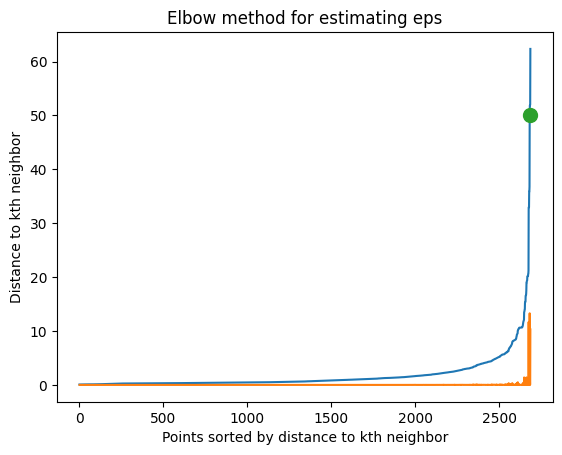

50.07228024366462


In [ ]:
x=elbow_method(data_DBSCAN,41)
print(x)

In [ ]:
y_train=np.array(y_train)
y_train=y_train.flatten()
y=np.empty([y_train.shape[0]],dtype='object')
y_true=np.empty([y_train.shape[0]],dtype='object')
labels=[]
k=len(unique_labels)-1
for q in range(k):
    y_predict=[]
    for p in indices[q]:
      y_predict.append((y_train[p]))
    if not y_predict:
      labels.append('empty')
    else:
      labels.append(mode(y_predict))
for q in range(k):
  for p in indices[q]:
      if (labels[q]!=None):
        y[p]=labels[q]
        y_true[p]=y_train[p]

In [ ]:
y_true=y_true.flatten()
y=np.array(y)

In [ ]:
y=y.flatten()

In [ ]:
y_true=y_true[y_true != np.array(None)]
y=y[y != np.array(None)]

Evaluation for the DBSCAN

In [ ]:
Evaluation(y_true,y,data_DBSCAN,indices,targets)

Model precision = 100.0%
Model recall = 100.0%
Model f_sore = 100.0%
Condition entropy = 0.0


Another Implementation for Evaluation

In [ ]:
def Precision(data_arr, clusters, targets):
    preci = np.zeros((len(clusters)))
    indx = 0
    for cluster in clusters:
        count = np.zeros(len(targets))
        for i in cluster:
            for j in range(len(targets)):
                if data_arr[i,-1] == targets[j]:
                    count[j] = count[j] + 1
                    break
        maxm = np.argmax(count)
        preci[indx] = count[maxm]/len(cluster)
        indx = indx + 1
    return preci

def Recall(data_arr, clusters, targets, targets_no):
    reci = np.zeros(len(clusters))
    indx = 0
    for cluster in clusters:
        count = np.zeros(len(targets))
        for i in cluster:
            for j in range(len(targets)):
                if data_arr[i,-1] == targets[j]:
                    count[j] = count[j] + 1
                    break
        maxm = np.argmax(count)
        reci[indx] = count[maxm] / targets_no[maxm]
        indx = indx + 1
    return reci
def F_score(preci, reci):
    fsum = 0
    for i in range(len(clusters)):
        fsum = fsum + 2 /((1/preci[i]) + (1/reci[i]))
    score = fsum / len(clusters)
    return score